### play around with the 12CO data to see if there is evidence for a previous outburst

#### 11/18/22  jpw

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from radio_beam import Beam
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.patches import Ellipse
from astropy.visualization import (MinMaxInterval, SqrtStretch, SinhStretch, AsinhStretch, LogStretch, ImageNormalize)
%matplotlib inline

In [2]:
filename1 = "data/12co.fits"

In [3]:
hdu1 = fits.open(filename1)[0]
d1 = hdu1.data.squeeze()
h1 = hdu1.header
b1 = Beam.from_fits_header(h1)
print(b1)

Beam: BMAJ=0.230157673578396 arcsec BMIN=0.15555069177192 arcsec BPA=-64.58953622277 deg


In [4]:
vla1 = SkyCoord('16h27m26.906s', '-24d40m50.82s', frame='icrs')

In [23]:
def plot_channels(cube, h, v0, v1, dv=None, vmin=None, vmax=None, extent=None, ellipse=True, jet=False, extrapolate_position=True, pdf=None):
    ra  = h['CRVAL1'] + (1+np.arange(h['NAXIS1'])-h['CRPIX1'])*h['CDELT1']    # degrees
    dec = h['CRVAL2'] + (1+np.arange(h['NAXIS2'])-h['CRPIX2'])*h['CDELT2']
    dra = (ra - vla1.ra.value) * 3600
    ddec = (dec - vla1.dec.value) * 3600
    if extent == None:
        extent = [dra[0], dra[-1], ddec[0], ddec[-1]]
        imin = 0
        imax = h['NAXIS1']-1
        jmin = 0
        jmax = h['NAXIS2']-1
    else:
        extent = extent
        imin = np.argmin(np.abs(dra-extent[0]))
        imax = np.argmin(np.abs(dra-extent[1]))
        jmin = np.argmin(np.abs(ddec-extent[2]))
        jmax = np.argmin(np.abs(ddec-extent[3]))
    asp = np.abs((extent[3] - extent[2]) / (extent[1] - extent[0]))
        
    nu   = h['CRVAL3']+(1+np.arange(h['NAXIS3'])-h['CRPIX3'])*h['CDELT3']   # Hz
    cc   = 2.9979e5
    nu0  = 230.5380000e9
    v    = cc * (nu-nu0)/nu0     # km/s
    delta_v = cc * h['CDELT3']/nu0
    k0 = np.argmin(np.abs(v-v0))
    k1 = np.argmin(np.abs(v-v1))
    try:
        dk = np.max([int(np.fix(np.abs(dv/delta_v))),1])
    except:
        dk=1
    
    nplot = int((k0-k1)/dk)+1
    ny = int(np.fix(np.sqrt(nplot)))
    nx = int(np.fix(nplot/ny + 0.99))
    sx = 16
    fig = plt.figure(figsize=(sx,asp*sx*ny/nx))
    for n in range(nplot):
        plot_index = nplot-n
        cube_index = k1+n*dk
        ax = plt.subplot(ny, nx, plot_index)
        im = cube[cube_index, jmin:jmax, imin:imax]
        norm = ImageNormalize(im, vmin=vmin, vmax=vmax, stretch=SqrtStretch())
        ax.imshow(im, extent=extent, origin='lower', norm=norm)
        ax.text(0.95, 0.88, f"{v[cube_index]:4.2f}", color='white', ha='right', fontsize=10, transform=ax.transAxes)
        
        #ticks = np.arange(-10,11,5)
        #ax.set_xticks(ticks)
        #ax.set_yticks(ticks)
        ax.grid(ls=':', lw=1)
        ax.plot(0, 0, '+', color='red', ms=10, mew=2, zorder=999)

        if plot_index == nplot-nx+1:
            ax.set_xlabel(r"$\Delta\alpha ('')$")
            ax.set_ylabel(r"$\Delta\delta ('')$")
            #beam = Ellipse((xb,yb), bmaj, bmin, angle=90-bpa, edgecolor='white', facecolor='none', linewidth=2)
            #ax.add_patch(beam)
        else:
            ax.set_xticklabels([])
            ax.set_yticklabels([])

        if extrapolate_position:
            t = 130
            mu_ra = -7.6
            mu_ra_err = 0.5
            mu_dec = -25.3
            mu_dec_err = 0.4
            
            x0 = -mu_ra * (t/1000)
            y0 = -mu_dec * (t/1000)
            ax.plot([1.8*x0, 0], [1.8*y0, 0], '-', color='cyan', alpha=0.7)
            ax.scatter(x0, y0, color='None', edgecolor='cyan')

            
        x_ring = x0
        y_ring = y0
        incl_ring = 15.0
        asp_ring = 0.5
        v_ring = -10.0
        width_ring = 4.0 + 0.6*(v[cube_index]-v_ring)
        if ellipse:
            e = Ellipse(xy=(x_ring,y_ring), width=width_ring, height=asp_ring*r_ring, angle=incl_ring)
            ax.add_artist(e)
            e.set_edgecolor('white')
            e.set_facecolor('None')
            e.set_linestyle(':')
            e.set_linewidth(2)
            e.set_alpha(1)
                    
        if jet:
            ax.arrow(0, 0, 0.5*x_ring, 0.5*y_ring, width=0.05, head_width=0.4, color='cyan')
            ax.arrow(0, 0, -0.5*x_ring, -0.5*y_ring, width=0.05, head_width=0.4, color='cyan')

    fig.tight_layout()
    try:
        plt.savefig(pdf)
        print("Image saved as "+pdf)
    except:
        pass

Image saved as bubble130.pdf


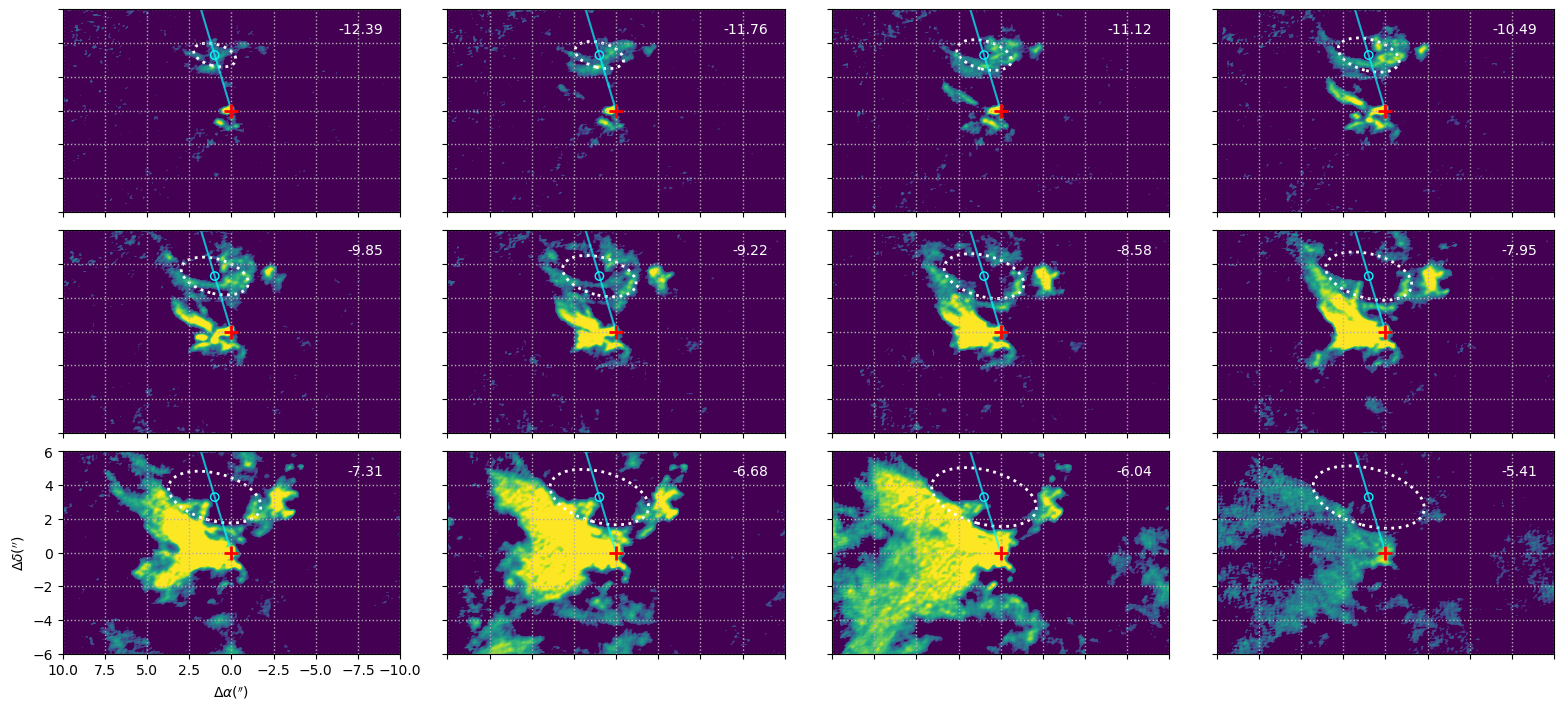

In [24]:
plot_channels(d1, h1, -12.5, -5.1, dv=0.5, extent = [10, -10, -6, 6], pdf="bubble130.pdf", vmin=0.005, vmax=0.05)

In [33]:
# radius of bubble (max value in the channel maps)
v0 = -5.41
v_ring = -10.0
width_ring = 4.0 + 0.6*(v0-v_ring)
print(0.5*width_ring * 137.3)

463.6621
